# Thickness estimation for pCO2 Silicone layer NN

In [1]:
# Import

# Imported from other script(Classification model)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
import math
#import imblearn
#import cv2 as cv

import imageio

from PIL import Image
import PIL

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage.color import rgb2grey
from skimage.io import imread
from skimage.io import imsave
from skimage import color
from skimage.transform import hough_circle
from skimage.transform import hough_ellipse, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix


from keras.preprocessing.image import ImageDataGenerator
#from imblearn.over_sampling import SMOTE

	
from datetime import datetime



#Plotting parameters
# plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams["axes.grid"] = False

Using TensorFlow backend.


Lets take a look on the data

In [2]:

labels = pd.read_excel("C:/Users/caspe/Desktop/MasterThesis/initial_set/4/thickness_estimation.xlsx", index_col= "Image ID")
labels = labels.drop(["Old Name","OK", "array_ID_board", "Array_ID_run"], axis = 1) 
#labels.drop(labels.tail(n).index,inplace=True) # drop last n rows
labels = labels.dropna()
labels.head(7)


,New Name,Path,Band,Sensor_ID,Label,Thickness
Image ID,,,,,,
0,932-028R10929N001_Array=01_001.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,1,0,1,56.912
1,932-028R10929N001_Array=01_002.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,2,0,1,56.912
2,932-028R10929N001_Array=01_003.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,3,0,1,56.912
3,932-028R10929N001_Array=01_004.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,4,0,1,56.912
4,932-028R10929N001_Array=01_005.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,5,0,1,56.912
5,932-028R10929N001_Array=01_006.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,6,0,1,56.912
6,932-028R10929N001_Array=02_001.png,C:\Users\caspe\Desktop\MasterThesis\initial_se...,1,1,1,51.620


First, there are some values in the 3D scanning, noted as errors since the scanning of these sensors were lacking in some way or another. Lets remove them from this data. 

In [3]:
#Labels prior to removal
labels.describe()

,Band,Sensor_ID,Label,Thickness
count,9984.000000,9984.000000,9984.0,9984.000000
mean,3.500000,831.500000,1.0,51.212919
std,1.707911,480.379395,0.0,7.643830
min,1.000000,0.000000,1.0,0.000000
25%,2.000000,415.750000,1.0,49.073750
50%,3.500000,831.500000,1.0,52.039000
75%,5.000000,1247.250000,1.0,54.520250
max,6.000000,1663.000000,1.0,83.148000


In [4]:
labels.dtypes

New Name      object
Path          object
Band           int64
Sensor_ID      int64
Label          int64
Thickness    float64
dtype: object

Lets remove everything below 20 in thickness from the dataframe. This is the lower limit for acceptaple thickness.

In [5]:
print('df before drop', labels.shape)
# = labels.replace(np.nan , 0)
labels.drop(labels[labels.Thickness < 20].index, inplace=True)
print('df after drop thickness <20', labels.shape)
labels.dropna()
print('df after drop N/A values', labels.shape)
#labels.describe()

df before drop (9984, 6)
df after drop thickness <20 (9936, 6)
df after drop N/A values (9936, 6)


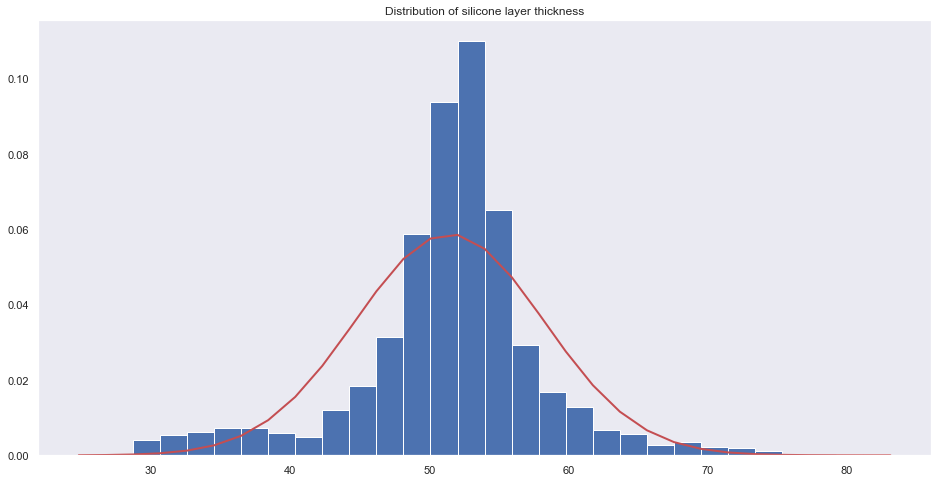

In [6]:
mu = labels["Thickness"].mean()
sigma = labels["Thickness"].std()
s = labels["Thickness"]
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Distribution of silicone layer thickness")
plt.show()

## Functions

In [7]:
def get_path_and_image_name(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img=Image.open(file_path)
    #img = resize(img, (1750, 1750), anti_aliasing=True)
    return np.array(img)


In [8]:
def get_image_in_pil(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    
    image = Image.open(file_path) 
    #image.load()
    return image

In [9]:
def get_image_in_pil_resize(df, Image_ID, size):
    #Assuming quadratic resize
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    
    image = Image.open(file_path) 
    image = image.resize((size, size))
    #image.load()
    return image

In [10]:
def get_path_and_image_name_resized(df, Image_ID, size):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img = imread(file_path)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.array(img)


In [11]:
def get_file_path(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    return file_path

<Figure size 1080x792 with 0 Axes>

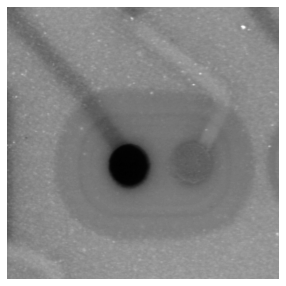

In [12]:
#A image of one of the discarded sensors
plt.figure(figsize=(15, 11))
temp = 6*12
image = imread(get_file_path(labels,temp+5), as_gray=True)

image = resize(image, (500, 500), anti_aliasing=True)

plt.figure(figsize=(7, 5))
plt.imshow(image, cmap='gray')
#plt.title("Approved sensor, silicone")
plt.axis('off')
#plt.savefig('IMG_test')
plt.show()

In [13]:
def create_rgb_custom(df, img_id, mode = 'cox'):
    
    if mode == 'cox':
        r = get_path_and_image_name(df, img_id)
        g = get_path_and_image_name(df, img_id+1)
        b = get_path_and_image_name(df, img_id+2)
        
        rgb = np.dstack((r, g, b))
    if mode == 'dark':
        r = get_path_and_image_name(df, img_id+3)
        g = get_path_and_image_name(df, img_id+4)
        b = get_path_and_image_name(df, img_id+5)
        
        rgb = np.dstack((r, g, b))
    
    if mode == 'both':
        r1 = get_path_and_image_name(df, img_id)
        g1 = get_path_and_image_name(df, img_id+1)
        b1 = get_path_and_image_name(df, img_id+2)
        r2 = get_path_and_image_name(df, img_id+3)
        g2 = get_path_and_image_name(df, img_id+4)
        b2 = get_path_and_image_name(df, img_id+5)
        rgb = np.dstack((r1, g1, b1, r2, g2, b2))
        
    if mode == 'avg':
        r1 = get_path_and_image_name(df, img_id)
        g1 = get_path_and_image_name(df, img_id+1)
        b1 = get_path_and_image_name(df, img_id+2)
        r2 = get_path_and_image_name(df, img_id+3)
        g2 = get_path_and_image_name(df, img_id+4)
        b2 = get_path_and_image_name(df, img_id+5)
        
        r = (r1/2)+(r2/2)
        g = (g1/2)+(g2/2)
        b = (b1/2)+(b2/2)
        rgb = np.dstack((r,g,b))
        rgb = np.round(rgb)
        rgb = rgb.astype(int)
        
        
        
#         r = (r1+r2)/2
#         g = (g1+g2)/2
        #b = (b1+b2)/2
#         r = ((np.array(r1)+np.array(r2))/2)
#         g = ((np.array(g1)+np.array(g2))/2)
#         b = ((np.array(b1)+np.array(b2))/2)
        
#         rgb = np.dstack((r, g, b))
#         rgb = np.round(rgb)
#         rgb = rgb.astype(int)
        
#     mask = get_crop_mask(img_id+2)
#     rgb = crop_image2(rgb, mask)
    #if scale = True:
        
    #rgb = resize(rgb, (size, size), anti_aliasing=True)     
    return rgb
        
        
        
    
        
        
image = create_rgb_custom(labels, 60,  mode='avg')
#print('image shape,' image.shape())
#image = resize(image, (500, 500))
img_max=image.max()
img_min=image.min()
img_mean=image.mean()
img_std=image.std()

print('max', img_max)
print('min', img_min)
print('mean', img_mean)
print('std', img_std)

max 220
min 18
mean 87.72987990689948
std 25.685545389066206


<Figure size 1080x792 with 0 Axes>

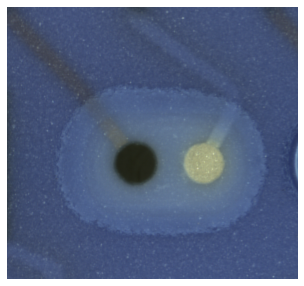

array([[[ 50,  58,  79],
        [ 53,  62,  78],
        [ 57,  64,  80],
        ...,
        [ 64,  80, 118],
        [ 65,  72, 122],
        [ 66,  77, 121]],

       [[ 52,  60,  82],
        [ 54,  64,  82],
        [ 55,  62,  80],
        ...,
        [ 65,  80, 122],
        [ 65,  78, 124],
        [ 66,  79, 122]],

       [[ 52,  60,  81],
        [ 53,  64,  78],
        [ 54,  66,  80],
        ...,
        [ 65,  80, 114],
        [ 66,  77, 120],
        [ 67,  81, 119]],

       ...,

       [[ 76,  86, 128],
        [ 73,  84, 124],
        [ 71,  85, 122],
        ...,
        [ 68,  80, 121],
        [ 68,  78, 123],
        [ 70,  80, 120]],

       [[ 74,  93, 124],
        [ 71,  88, 124],
        [ 72,  86, 122],
        ...,
        [ 68,  84, 122],
        [ 70,  82, 125],
        [ 68,  86, 121]],

       [[ 73,  92, 126],
        [ 74,  90, 122],
        [ 74,  84, 120],
        ...,
        [ 70,  80, 122],
        [ 68,  78, 124],
        [ 68,  82, 121]]

In [14]:
#A image of one of the discarded sensors
plt.figure(figsize=(15, 11))

image = create_rgb_custom(labels, 6, mode ='avg')
#mask  = get_crop_mask(60+2)
#image = crop_image2(image, mask)
#image = resize(image, (500, 500), anti_aliasing=True)

plt.figure(figsize=(7, 5))
plt.imshow(image)
#plt.title("Approved sensor, silicone")
plt.axis('off')
#plt.savefig('IMG_test')
plt.show()
image

## Cropping

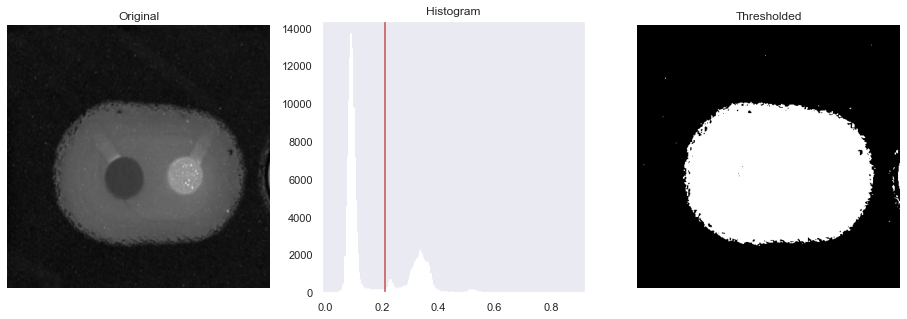

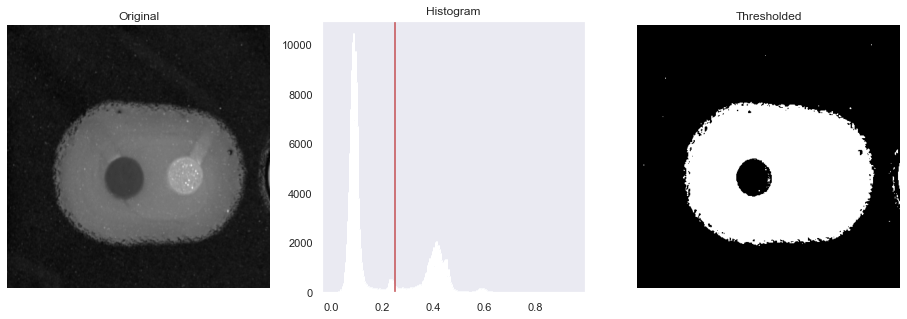

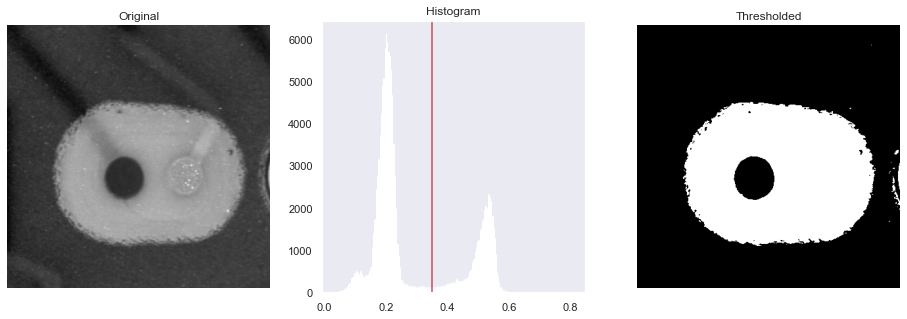

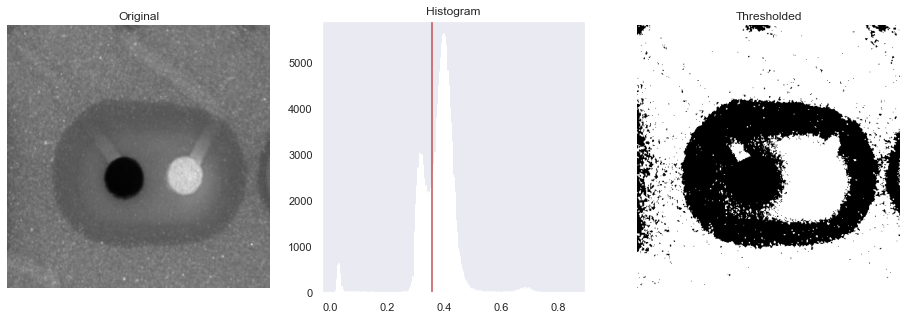

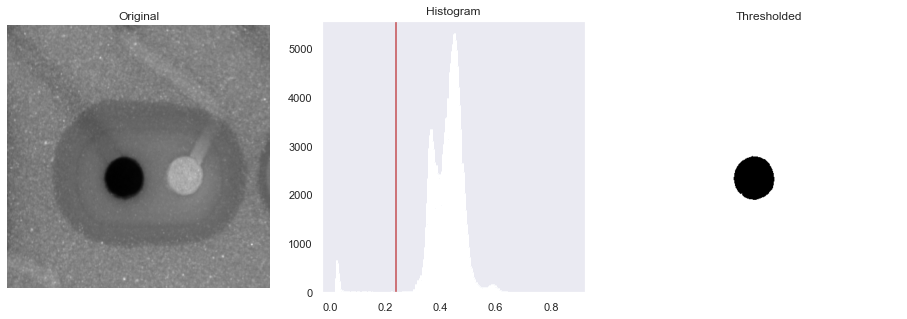

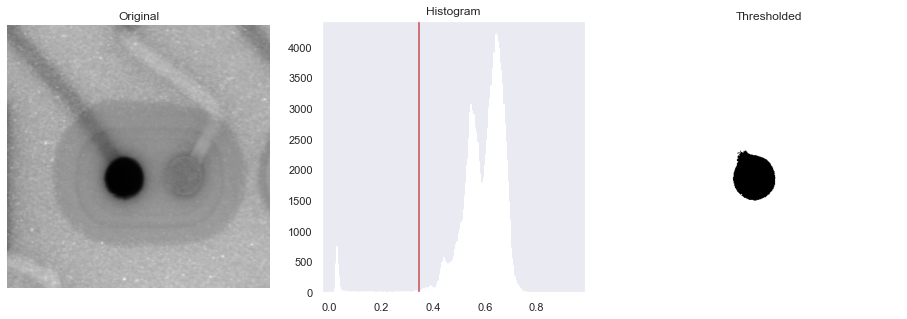

In [15]:
for img_id in range(6):
    image = get_path_and_image_name(labels, (60)+img_id) #300 - tush marker, #54 - total smushed sensor,
    image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(16, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    plt.show()


In [16]:
def crop_image(img_id, tol=0): # not used
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [17]:
def get_crop_mask(img_id, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask1', mask)
    #return image[np.ix_(mask.any(1),mask.any(0))]
    return mask

In [18]:
def crop_image2(img_id, Mask, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    mask = Mask
    #print('mask2', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [19]:
def crop_image3(image, Mask, tol=0):
    
    image = image
    mask = Mask
    #print('mask2', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [20]:
def get_shape_in_mm(image):
    res = 0.0021
    print('width:', image.shape[0]*res)
    print('length:', image.shape[1]*res)

<Figure size 1080x792 with 0 Axes>

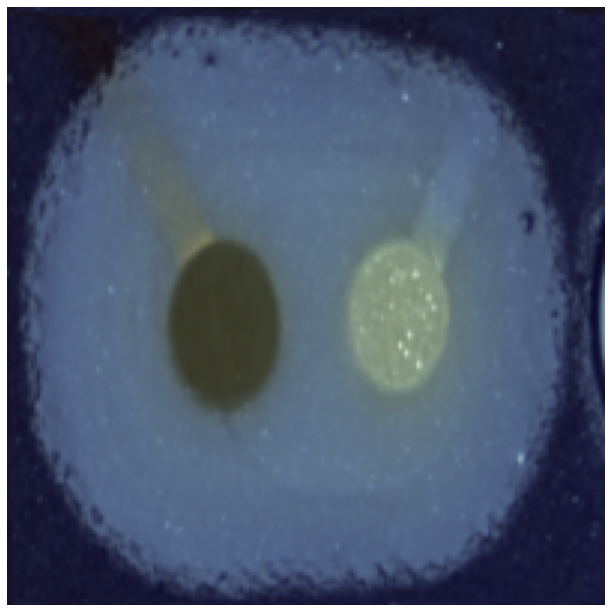

array([[[0.08888005, 0.08103691, 0.1487451 ],
        [0.09130392, 0.08959113, 0.19047059],
        [0.08235294, 0.08235294, 0.18739216],
        ...,
        [0.09031201, 0.07577623, 0.15571569],
        [0.09803922, 0.08935294, 0.16301961],
        [0.08711765, 0.08019377, 0.16217647]],

       [[0.09803922, 0.07843137, 0.13833623],
        [0.09311877, 0.07269495, 0.12966667],
        [0.08627451, 0.07843137, 0.15910784],
        ...,
        [0.10588235, 0.08627451, 0.12801961],
        [0.09803922, 0.07843137, 0.12409804],
        [0.09803922, 0.08235294, 0.11705191]],

       [[0.09227279, 0.08235294, 0.17860956],
        [0.1248875 , 0.12445098, 0.18859804],
        [0.10279412, 0.08714828, 0.13111887],
        ...,
        [0.09803922, 0.09754044, 0.18519608],
        [0.09019608, 0.0904902 , 0.18490196],
        [0.09988407, 0.10017819, 0.18894926]],

       ...,

       [[0.07606054, 0.0627451 , 0.14329583],
        [0.0745098 , 0.07058824, 0.16854436],
        [0.08573529, 0

In [21]:
#A image of one of the discarded sensors
plt.figure(figsize=(15, 11))

image = create_rgb_custom(labels, 60, mode ='cox')
mask  = get_crop_mask(60+2)
image = crop_image3(image, mask)
image = resize(image, (200, 200), anti_aliasing=True)

plt.figure(figsize=(15,11))
plt.imshow(image)
#plt.title("Approved sensor, silicone")
plt.axis('off')
#plt.savefig('IMG_test')
plt.show()

image

## NN preprocess

In [22]:
image_list = []
size_images = 250
for img_id in range(len(labels)):
#for img_id in range(bug_fix):
    if (img_id % 250) == 0:
        print('Date/Time:', datetime.now(),'-------Image ID:', img_id)
    if labels.iloc[img_id,2] == 1: #if this is the first band, proceed
        image = create_rgb_custom(labels, img_id, mode = 'cox')
        
#         mask = get_crop_mask(img_id+2, tol=0)
#         image = crop_image2(image, mask, tol=0)
        image = resize(image, (size_images, size_images), anti_aliasing=True)
        #image = np.array(image)
        image_list.append(image)


image_list_arr = np.array(image_list, dtype=np.float32)
print('image_list length:', len(image_list_arr))
print('Shape of one element:',image_list_arr[1].shape)
print('image_mean', image_list_arr.mean())
print('image_std', image_list_arr.std())


Date/Time: 2020-06-17 18:10:22.078397 -------Image ID: 0
Date/Time: 2020-06-17 18:10:59.361857 -------Image ID: 250
Date/Time: 2020-06-17 18:11:37.254110 -------Image ID: 500
Date/Time: 2020-06-17 18:12:13.417597 -------Image ID: 750
Date/Time: 2020-06-17 18:12:50.703195 -------Image ID: 1000
Date/Time: 2020-06-17 18:13:34.971473 -------Image ID: 1250
Date/Time: 2020-06-17 18:14:21.854961 -------Image ID: 1500
Date/Time: 2020-06-17 18:14:59.435162 -------Image ID: 1750
Date/Time: 2020-06-17 18:15:36.872105 -------Image ID: 2000
Date/Time: 2020-06-17 18:16:13.277421 -------Image ID: 2250
Date/Time: 2020-06-17 18:16:49.864354 -------Image ID: 2500
Date/Time: 2020-06-17 18:17:26.891068 -------Image ID: 2750
Date/Time: 2020-06-17 18:18:03.319682 -------Image ID: 3000
Date/Time: 2020-06-17 18:18:39.987372 -------Image ID: 3250
Date/Time: 2020-06-17 18:19:17.183623 -------Image ID: 3500
Date/Time: 2020-06-17 18:19:53.455485 -------Image ID: 3750
Date/Time: 2020-06-17 18:20:32.155405 -------I

In [23]:

image_list_arr = np.array(image_list, dtype=np.float32)

print('image_list length:', len(image_list_arr))
print('Shape of one element:',image_list_arr[1].shape)
print('image_mean', image_list_arr.mean())
print('image_std', image_list_arr.std())
print('image_max', image_list_arr.max())
print('image_min', image_list_arr.min())

image_list length: 1656
Shape of one element: (250, 250, 3)
image_mean 0.1908061
image_std 0.14383602
image_max 0.9919765
image_min 0.003921569


In [24]:
#Dropping all images that is not the first band(we represent one sensor only one time)
labels_df = labels[labels.Band ==1]
#set index to sensor ID
labels_df = labels_df.set_index('Sensor_ID')
#dropping information that is not needed.
labels_df = labels_df.drop(["Band", "Label"], axis = 1)

#Define x and y... x is actually not used
X_df = labels_df.drop(["Thickness"], axis=1)
y_df = labels_df.drop(["New Name", "Path"], axis=1)


y_max = y_df.max()
y_min = y_df.min()
y_mean = y_df.mean()
y_std = y_df.std()
y_df = y_df/y_max
y_df = y_df.to_numpy()
y_df = np.array(y_df)
print('y_max',y_max)
print('y_min',y_min)
print('y_mean', y_mean)
print('y_std', y_std)



y_max Thickness    83.148
dtype: float64
y_min Thickness    24.812
dtype: float64
y_mean Thickness    51.458467
dtype: float64
y_std Thickness    6.796202
dtype: float64


In [25]:
X_train, X_test, y_train, y_test = train_test_split(image_list_arr, y_df, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
print('shape of X_train', X_train.shape)
print('shape of y_train', y_train.shape)
print('---------------------------')
print('shape of X_test', X_test.shape)
print('shape of y_test', y_test.shape)
print('---------------------------')
print('shape of X_val', X_val.shape)
print('Shape of y_val', y_val.shape)

shape of X_train (993, 250, 250, 3)
shape of y_train (993, 1)
---------------------------
shape of X_test (332, 250, 250, 3)
shape of y_test (332, 1)
---------------------------
shape of X_val (331, 250, 250, 3)
Shape of y_val (331, 1)


# Keras Modellos

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras import metrics
from keras.constraints import MinMaxNorm
from sklearn.metrics import r2_score
import math

# custom R2-score metrics for keras backend
from keras import backend as K



In [27]:
def CNN_regr(width, height, depth, filters=(16, 64, 150)):
    inputshape= (height, width, depth)
    chandim = -1
    
    #model input
    inputs = Input(shape=inputshape)
    #convd
    for (i, f) in enumerate(filters):
        if i == 0:
            x = inputs
            
        x = Conv2D(f, (3,3), padding='same') (x)
        x = Activation('relu')(x)
        x = BatchNormalization(axis=chandim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    #flatten
    x = Flatten() (x)

    
    #FC 
    #x = Dense(1000)(x)
    #x = Dropout(0.3) (x)
    #x = Activation('relu')(x)
    
#     x = Dense(1000)(x)
#     x = Dropout(0.5) (x)
#     x = Activation('relu')(x)
    
    x = Dense(500)(x)
    x = Dropout(0.3) (x)
    x = Activation('relu')(x)
    
#     x = Dense(500)(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5) (x)
    
    #output
    x = Dense(1, activation ='linear')(x)

   
    
    
    model = Model(inputs, x)
    
    return model
    


In [28]:
model = CNN_regr(size_images, size_images, 3)

In [29]:
#Loss = 'mean_squared_error'
#Loss = 'mean_absolute_error'
#Loss = 'mean_squared_logarithmic_error'

Loss ='mean_absolute_percentage_error'

In [30]:
#opt = SGD(lr=0.01, momentum=0.9, clipvalue=1.0)
opt = Adam(lr=1e-3, decay=1e-3/200)

#opt = Adam(lr=1e-3)
#opt = RMSprop(learning_rate=0.001, rho=0.9)


In [31]:
#model.compile(loss='mean_absolute_percentage_error', optimizer=RMSprop(learning_rate=0.1))
model.compile(loss=Loss, optimizer=opt, metrics=['mae', 'acc'])

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 64)      0   

In [33]:
print('Queue eye of the tiger, its training time!')
print(' Dum, dum dum dum, dum dum duuuuuum, Dum, dum dum dum, dum dum duuuuuum ')

Queue eye of the tiger, its training time!
 Dum, dum dum dum, dum dum duuuuuum, Dum, dum dum dum, dum dum duuuuuum 


In [34]:
#model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=20, batch_size = 1)
#model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=5)

Train on 993 samples, validate on 331 samples
Epoch 1/30
993/993 [==============================] - 485s 488ms/step - loss: 2458.6778 - mae: 14.9052 - acc: 0.0000e+00 - val_loss: 3684.9567 - val_mae: 22.2788 - val_acc: 0.0000e+00
Epoch 2/30
993/993 [==============================] - 479s 483ms/step - loss: 88.9354 - mae: 0.5499 - acc: 0.0000e+00 - val_loss: 4140.8584 - val_mae: 24.8797 - val_acc: 0.0000e+00
Epoch 3/30
993/993 [==============================] - 442s 445ms/step - loss: 59.2052 - mae: 0.3715 - acc: 0.0000e+00 - val_loss: 3781.3295 - val_mae: 22.9562 - val_acc: 0.0000e+00
Epoch 4/30
993/993 [==============================] - 436s 439ms/step - loss: 41.7741 - mae: 0.2652 - acc: 0.0000e+00 - val_loss: 285.3119 - val_mae: 1.7646 - val_acc: 0.0000e+00
Epoch 5/30
993/993 [==============================] - 443s 446ms/step - loss: 18.5840 - mae: 0.1180 - acc: 0.0000e+00 - val_loss: 26.1011 - val_mae: 0.1592 - val_acc: 0.0030
Epoch 6/30
993/993 [==============================] - 4

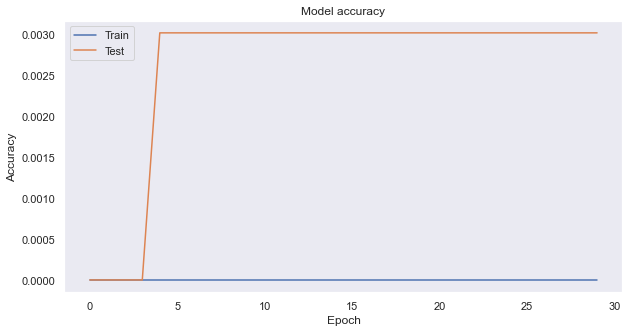

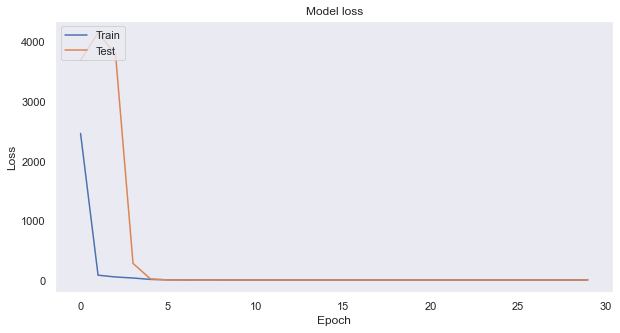

In [35]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size =8)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
preds = model.predict(X_test)

In [37]:
preds = preds *83.148

In [38]:
prediction = pd.DataFrame(preds, columns = ['prediction'])
prediction[('test')]=y_test*83.148
prediction[('diff')]=prediction[('test')]-prediction[('prediction')]
prediction.head()

,prediction,test,diff
0,51.070896,50.916,-0.154896
1,51.070896,62.436,11.365104
2,51.070896,49.443,-1.627896
3,51.070896,46.708,-4.362896
4,51.070896,54.689,3.618104


In [39]:
prediction=prediction.sort_values(by=['test'])
prediction = prediction.reset_index()
prediction.describe()

,index,prediction,test,diff
count,332.000000,332.000000,332.000000,332.000000
mean,165.500000,51.071037,51.389461,0.318565
std,95.984374,0.000141,6.825734,6.825734
min,0.000000,51.070896,28.912000,-22.158896
25%,82.750000,51.070896,49.413500,-1.657396
50%,165.500000,51.070896,52.048000,0.977104
75%,248.250000,51.070896,54.704250,3.633354
max,331.000000,51.070896,76.115000,25.044104


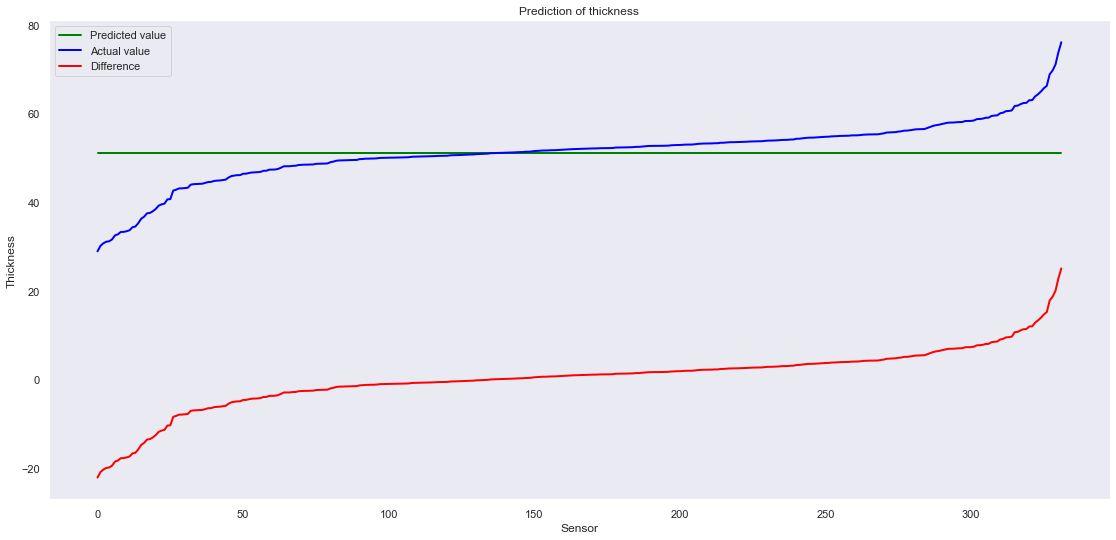

In [40]:
plt.rcParams['figure.figsize'] = (16, 8)
# GG-Plot version
data1 = prediction[('prediction')]
data2 = prediction[('test')]
data3 = prediction[('diff')]



fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 23})
ax1.set_xlabel('Sensor')
ax1.set_ylabel('Thickness')
ax1.plot(data1, color='green', label='Predicted value', linewidth=2)
ax1.plot(data2, color='blue', label='Actual value', linewidth=2)
ax1.plot(data3, color='red', label='Difference', linewidth=2)


#ax1.set_xlim(left=0, right=2.5, emit=True, auto=False)
#ax1.set_ylim(bottom=-21, top=21)
#ax1.xaxis.set_major_formatter(x_formatter)
#ax1.xaxis.set_major_locator(x_locator)
ax1.legend()
plt.savefig('NN_prediction3.png',)
plt.title('Prediction of thickness')
fig.tight_layout() 

plt.show()

In [41]:
a = r2_score(prediction[("test")], prediction[("prediction")])
print(a)

-0.0021847748303325254


In [42]:
diff = preds.flatten() - y_val
percentDiff = (diff / y_val) * 100
absPercentDiff = np.abs(percentDiff)

In [43]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [44]:
r2_keras(y_test, preds)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [ ]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
coeff_determination(y_test, preds)

# To do
- Image generator
- cropping
- additional data
- decrease majority imbalance
- potentially limit thickness estimation to 60 mu +